In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

from env import *
from states import *
from agents import *
from models import *
from util import *

/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hanqiu/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

### Training Pipeline

#### DQN

First, train an DQN model.

In [ ]:
version = 5

In [ ]:
## initialize model
q_model = QModel(save_dir='model/')
q_model.learn_iter = 1
curr_iter = 0
q_model.save('dqn-v{}/{}'.format(version,curr_iter))
q_model.restore('dqn-v{}/{}'.format(version,curr_iter))

In [ ]:
## train model using DQN
agent = RlAgent(q_model)
agent.sample_collect_flag = True
agents = [agent,agent,agent,agent]

tt = time.time()
N_iter_inner = 10000
for iter_outer in range(50):
    run_games(N_iter=N_iter_inner,agents=agents,if_train=True,models=[q_model],state_generator=StateExtend)
    q_model.save('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))
    q_model.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))
    print('{}:{:.2f}'.format(iter_outer+1,time.time() - tt))
    
    if iter_outer % 10 == 0 and iter_outer > 0:
        ## do some evaluation
        q_model_1 = QModel(save_dir='model/')
        q_model_1.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1-10)*N_iter_inner))
        q_model_2 = QModel(save_dir='model/')
        q_model_2.partial_restore('dqn-v{}/{}'.format(version,curr_iter+(iter_outer+1)*N_iter_inner))

        a_base = Agent()
        a_rl_1 = RlAgent(q_model_1)
        a_rl_2 = RlAgent(q_model_2)
        for a in [a_base,a_rl_1,a_rl_2]:
            a.infer_flag = True

        eval_results = []
        for agents in [[a_rl_1,a_base,a_rl_1,a_base],
                       [a_rl_2,a_rl_1,a_rl_2,a_rl_1],
                      ]:

            ttt = time.time()
            curr_scores,eval_scores = \
                run_games(N_iter=1000,agents=agents,if_random_game=False,
                          fname='dataset/valid_set_q.p',state_generator=StateExtend)
#             print(time.time()-ttt,np.mean(curr_scores),np.mean(eval_scores))
            eval_results.append(np.mean(eval_scores))
        print(iter_outer,'eval results:',eval_results)

#### MCTS

Next, train an MCTS model.

In [ ]:
version = 7

In [ ]:
## initialize model
mcts_model = MCTSModel(save_dir='model/')
# mcts_model.partial_restore('dqn-v5/100000')
mcts_model.save('mcts-v{}/0'.format(version))

In [ ]:
import pickle
import os
import glob
import ray
from tqdm import tqdm

def collect_samples(model_fname,iter_outer,N_iter_inner):
    mcts_model = MCTSModel(save_dir='model/')
    mcts_model.partial_restore(model_fname)
    e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
    sample_idx = '{}-{}'.format(os.getpid(),random.getrandbits(8))
    
    agent = MCTSAgent(mcts_model,e_sim,N_search=1600)
    agent.sample_collect_flag = True
    agents = [agent,agent,agent,agent]
    N_batch = 250
    tt = time.time()
    for iter_inner in range(N_iter_inner//N_batch):
        run_games(N_iter=N_batch,agents=agents,state_generator=StateExtend)
        with open('dataset/mcts-v{}/{}/data_sample_{}_{}.p'.format(
                    version,iter_outer,sample_idx,iter_inner),
                  'wb') as fb:
            pickle.dump(mcts_model.exp_pool,fb)
            mcts_model.clear_experience()
        print('{}-{}:{:.2f}'.format(os.getpid(),iter_inner+1,time.time() - tt))
        time.sleep(300)

@ray.remote
def collect_samples_ray(model_fname,iter_outer,N_iter_inner):
    return collect_samples(model_fname,iter_outer,N_iter_inner)

def load_exprience(model,fname):
    with open(fname,'rb') as fb:
        exp_pool = pickle.load(fb)
    model.exp_pool = exp_pool
    model.exp_pool_size = dict([(key,len(value)) for key,value in model.exp_pool.items()])
    
def ema(losses,factor=0.99):
    output = [losses[0]]
    for l in losses[1:]:
        output.append(factor * output[-1] + (1 - factor) * l)
    return output

In [ ]:
## train model using MCTS
N_threads = 4
N_iter_inner = 1000 // N_threads

curr_model_iter = 0
N_iter_train_inner = 1000
N_iter_train_outer = 1
valid_data_frac = 0.1
holdout_flag = False ## whether the training process has holdout valid set
factor = 0.99

tt = time.time()
ray.init()
for iter_outer in range(10):
    model_fname = 'mcts-v{}/{}'.format(version,curr_model_iter)
    
    ## collect samples
    if not os.path.exists('dataset/mcts-v{}/{}'.format(version,iter_outer)):
        os.mkdir('dataset/mcts-v{}/{}'.format(version,iter_outer))
    object_ids = [collect_samples_ray.remote(model_fname,iter_outer,N_iter_inner) for _ in range(N_threads)]
    ray.wait(object_ids, num_returns=len(object_ids))
    
    ## train models
    data_fnames_total = []
    for iter_ in range(max(iter_outer-5,0),iter_outer):
        data_fnames = glob.glob('dataset/mcts-v{}/{}/*.p'.format(version,iter_))
        data_fnames_total.extend(data_fnames)
    N_fnames = len(data_fnames_total)
    valid_data_fnames = [data_fnames_total[i] for i in np.random.choice(N_fnames,int(valid_data_frac*N_fnames))]
    if holdout_flag:
        data_fnames = list(set(data_fnames_total)-set(valid_data_fnames)) ## hold-out training
    else:
        data_fnames = data_fnames_total ## all training
    
    mcts_model = MCTSModel(save_dir='model/')
    mcts_model.restore(model_fname)
    mcts_model.learn_iter = 10
    prob_loss_all,q_loss_all = [],[]
    valid_prob_loss_all,valid_q_loss_all = [],[]
    
    for _ in range(N_iter_train_outer):
        for _ in tqdm(range(N_iter_train_inner)):
            data_fname = np.random.choice(data_fnames)
            load_exprience(mcts_model,data_fname)
            prob_loss_batches,q_loss_batches = mcts_model.learn()
            prob_loss_all.extend(prob_loss_batches)
            q_loss_all.extend(q_loss_batches)
            
            ## validation
            data_fname = np.random.choice(valid_data_fnames)
            load_exprience(mcts_model,data_fname)
            valid_prob_loss_batches,valid_q_loss_batches = mcts_model.eval()
            valid_prob_loss_all.extend(valid_prob_loss_batches)
            valid_q_loss_all.extend(valid_q_loss_batches)
        
        fig,axes = plt.subplots(2,2,figsize=(6,6))
        axes[0,0].plot(ema(prob_loss_all,factor),label='train P loss')
        axes[0,1].plot(ema(q_loss_all,factor),label='train Q loss')
        axes[1,0].plot(ema(valid_prob_loss_all,factor),label='valid P loss')
        axes[1,1].plot(ema(valid_q_loss_all,factor),label='valid Q loss')
        for ax in axes.ravel():
            ax.legend()
            ax.grid()
        plt.tight_layout()
        plt.show()
        
        curr_model_iter += N_iter_train_inner
        mcts_model.save('mcts-v{}/{}'.format(version,curr_model_iter))
        
    ## do some evaluation
    mcts_model_1 = MCTSModel(save_dir='model/')
    mcts_model_1.restore('mcts-v{}/{}'.format(version,curr_model_iter - N_iter_train_inner * N_iter_train_outer))
    mcts_model_2 = MCTSModel(save_dir='model/')
    mcts_model_2.restore('mcts-v{}/{}'.format(version,curr_model_iter))

    a_base = Agent()
    e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
    a_mcts_1 = MCTSAgent(mcts_model_1,e_sim,N_search=1600,c_puct=400)
    a_mcts_2 = MCTSAgent(mcts_model_2,e_sim,N_search=1600,c_puct=400)
    for a in [a_base,a_mcts_1,a_mcts_2]:
        a.infer_flag = True

    ttt = time.time()
    eval_results = []
    for agents in [
                   [a_mcts_1,a_base,a_mcts_1,a_base],
                   [a_mcts_2,a_mcts_1,a_mcts_2,a_mcts_1],
                  ]:
        curr_scores,eval_scores = \
            run_games(N_iter=100,agents=agents,if_random_game=False,
                      fname='dataset/valid_set_q.p',state_generator=StateExtend)
        eval_results.append(np.mean(eval_scores))
    print('{} eval time:{:.2f}; eval results:{}'.format(iter_outer,time.time()-ttt,eval_results))
        
    print('{}:{:.2f}'.format(iter_outer+1,time.time() - tt))
    
ray.shutdown()

##### benchmarking the learned agent

In [ ]:
mcts_model_1 = MCTSModel(save_dir='model/')
mcts_model_1.restore('mcts-v7/1000')
mcts_model_2 = MCTSModel(save_dir='model/')
mcts_model_2.restore('mcts-v7/5000')

In [ ]:
a_base = Agent()
e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
a_mcts_1 = MCTSAgent(mcts_model_1,e_sim,N_search=1600,c_puct=400)
a_mcts_2 = MCTSAgent(mcts_model_2,e_sim,N_search=1600,c_puct=400)
for a in [a_base,a_mcts_1,a_mcts_2]:
    a.infer_flag = True

ttt = time.time()
eval_results = []
for agents in [
                [a_mcts_2,a_base,a_mcts_2,a_base],
                [a_mcts_2,a_mcts_1,a_mcts_2,a_mcts_1],
              ]:
    curr_scores,eval_scores = \
        run_games(N_iter=100,agents=agents,if_random_game=False,
                  fname='dataset/valid_set_q.p',state_generator=StateExtend)
    eval_results.append(np.mean(eval_scores))
print('eval time:{:.2f}; eval results:{}'.format(time.time()-ttt,eval_results))

##### check whether the model learns well

In [4]:
## load the trained model
def softmax(arr):
    prob = np.exp(arr - np.max(arr))
    prob = prob / np.sum(prob)
    return prob

def eval_ent(arr):
    return np.sum(arr * np.log(np.maximum(arr,1e-8)))

mcts_model = MCTSModel(save_dir='model/')
mcts_model.restore('mcts-v{}/{}'.format(version,curr_model_iter))

data_fnames = glob.glob('dataset/mcts-v{}/{}/*.p'.format(version,iter_outer))
data_fname = np.random.choice(data_fnames)
load_exprience(mcts_model,data_fname)
dataset = mcts_model.exp_pool[0]

INFO:tensorflow:Restoring parameters from model/mcts-v5/260000/model


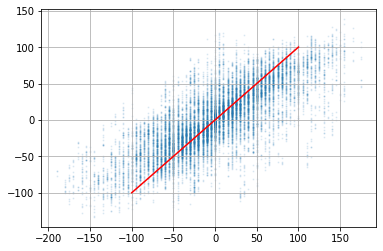

In [5]:
## do a batch inference
prob_loss_batches = []
prob_real_batches,value_real_batches = [],[]
logit_pred_batches,prob_pred_batches,value_pred_batches = [],[],[]
for exp in dataset:
    s_batch,As_batch,direc_batch,mask_len_batch,value_batch,probs_batch = [],[],[],[],[],[]
    for sample in [exp]:
        state_vec,actions_vec,direc,value,a_probs = sample
        mask_len_batch.append(actions_vec.shape[1])
    max_len = np.max(mask_len_batch)

    for sample in [exp]:
        state_vec,actions_vec,direc,value,a_probs = sample

        s_batch.append(state_vec)
        direc_batch.append(direc)
        value_batch.append(value)

        n_pad = max_len - actions_vec.shape[1]
        if n_pad > 0:
            actions_vec = np.concatenate([actions_vec,np.zeros((1,n_pad,55))],axis=1)
            a_probs = np.concatenate([a_probs,np.zeros((n_pad,))],axis=0)

        As_batch.append(actions_vec)
        probs_batch.append(a_probs)

    value_pred_batch,logit_pred_batch,prob_loss_batch = \
        mcts_model.sess.run([mcts_model.v_s_eval,mcts_model.logits_sAs_eval,
                                                            mcts_model.prob_loss],
                                {mcts_model.tfs:np.concatenate(s_batch,axis=0),
                                 mcts_model.tfAs:np.concatenate(As_batch,axis=0),
                                 mcts_model.tfprobs_sAs:np.stack(probs_batch,axis=0),
                                 mcts_model.tfv_s:np.array(value_batch),
                                 mcts_model.tfmask_len:np.array(mask_len_batch),
                                 mcts_model.tf_direc:np.array(direc_batch),
                                })
    prob_loss_batches.append(prob_loss_batch)
    logit_pred_batches.append((logit_pred_batch))
    prob_pred_batches.append(softmax(logit_pred_batch))
    value_pred_batches.append(value_pred_batch)
    prob_real_batches.append(np.stack(probs_batch,axis=0))
    value_real_batches.append(np.array(value_batch))
    
prob_loss_batches = np.array(prob_loss_batches)
value_pred_batches = np.array(value_pred_batches)
value_real_batches = np.array(value_real_batches)

plt.figure()
plt.scatter(value_real_batches[:,0],value_pred_batches[:,0],1,alpha=0.1)
plt.plot([-100,100],[-100,100],'r')
plt.grid()
plt.show()

In [ ]:
## compare the real labels and the predictions
for p1,p2 in zip(prob_real_batches,prob_pred_batches):
    print(np.stack([p1[0],p2[0]],axis=0),np.sum(p1[0] * np.log(p2[0])),eval_ent(p1[0]))

#### Speed Tests

In [ ]:
test_fname = 'dataset/speed_test_set.p'

In [ ]:
## load models
mcts_model = MCTSModel(save_dir='model/')
e_sim = Env(Game(),DefaultPlayer(),state_generator=StateExtend)
agent = MCTSAgent(mcts_model,e_sim,N_search=1600)
agent.sample_collect_flag = True
agents = [agent,agent,agent,agent]

In [ ]:
%%prun -s cumulative -l 50

_ = run_games(agents=agents,fname=test_fname,state_generator=StateExtend)

In [ ]:
%load_ext line_profiler

# %lprun -f agent.mcts_search run_games(agents=agents,fname=test_fname,state_generator=StateExtend)
%lprun -f agent.predict_node_batch run_games(agents=agents,fname=test_fname,state_generator=StateExtend)